# Week 12

#### Packages we will require this week

In [1]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "glmnet",
    "caret",
    "repr",
    "tidyverse",
    "mlbench",
    "nnet",
    "rpart",
    "e1071",
    # NEW
    "torch",
    "torchvision",
    "luz"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

Loading required package: ISLR2

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: readr

Loading required package: purrr

Loading required package: glmnet

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-4

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Loading required package: repr

Loading required package: tidyverse

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.1     v forcats 0.5.2
v stringr 1.4.1     
-- Conflicts -------------

ISLR2       dplyr       tidyr       readr       purrr      glmnet 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      caret        repr   tidyverse     mlbench        nnet       rpart 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      e1071       torch torchvision         luz 
       TRUE        TRUE       FALSE        TRUE

# Recap

------------------------------------------------------------------------

## Regression with Neural Networks

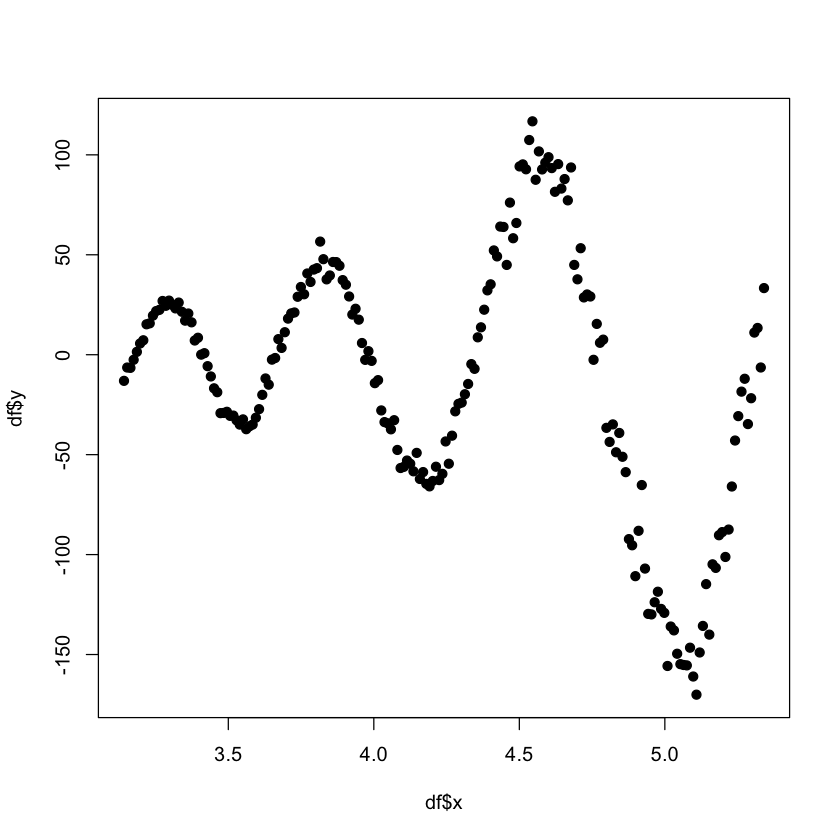

In [2]:
generate_data <- function(n, noise = 0.1) {
  x <- seq(1*pi, 1.7*pi, length.out = n)
  y <- exp(x) * (sin(150/x) + rnorm(n, 0, noise))
  data.frame(x = x, y = y)
}

df <- generate_data(200, noise=0.1)
plot(df$x, df$y, pch = 19)

In [3]:
x_new <- seq(0.9 * pi, 2.1 * pi, length.out=1000)
df_new <- data.frame(x = x_new)

plt_reg <- function(f, x,...){
    ynew <- f(x)
    ylim <- range(c(ynew, df$y))
    ylim[1] <- max(c(-800, ylim[1]))
    ylim[2] <- min(c(250, ylim[2]))
    xlim <- range(x)
    
    plot(df$x, df$y, pch = 22, col="red", xlim=xlim, ylim=ylim,...)
    points(x[, 1], ynew, pch=22, type="l")
}

------------------------------------------------------------------------

### Neural Network

In [4]:
p <- 1
q1 <- 20
q2 <- 100

reg_module <- nn_module(
  initialize = function() {
    self$input_to_hidden1 <- nn_linear(p, q1)
    self$hidden1_to_hidden2 <- nn_linear(q1, q2)
    self$hidden2_to_output <- nn_linear(q2, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
  forward = function(x) {
    x %>% 
      self$input_to_hidden1() %>% 
      self$activation() %>% 
      self$hidden1_to_hidden2() %>% 
      self$activation() %>% 
      self$hidden2_to_output()
  }
)

In [5]:
regressor <- 
function(train, type="nn", ...){
    
    if(type == "lm"){
        f = \(x) lm(y ~ x, df) %>% 
                    predict(., x)
    }
    
    else if(type == "rpart"){
        f = \(x) 
            rpart(y ~ x, df) %>% 
            predict(., x)
    }
        
    else if(type == "svm"){
        f = \(x)
            svm(y ~ x, df, kernel="radial") %>% 
            predict(., x)
    } 
        
    else if(type == "nn"){
        X_tensor <- torch_tensor(cbind(df$x %>% as.matrix()), dtype=torch_float())
        y_tensor <- torch_tensor(cbind(df$y %>% as.matrix()), dtype=torch_float())
        F <- reg_module()
        optimizer <- optim_adam(F$parameters, lr=0.2)
        epochs <- 1000

        for(i in 1:epochs){
            loss <- nn_mse_loss()(F(X_tensor), y_tensor)
            optimizer$zero_grad()
            loss$backward()
            optimizer$step()
        }
        f = \(x) as_array(F( torch_tensor(x %>% as.matrix(), dtype=torch_float()) ))
    }
    
    return(f)
}

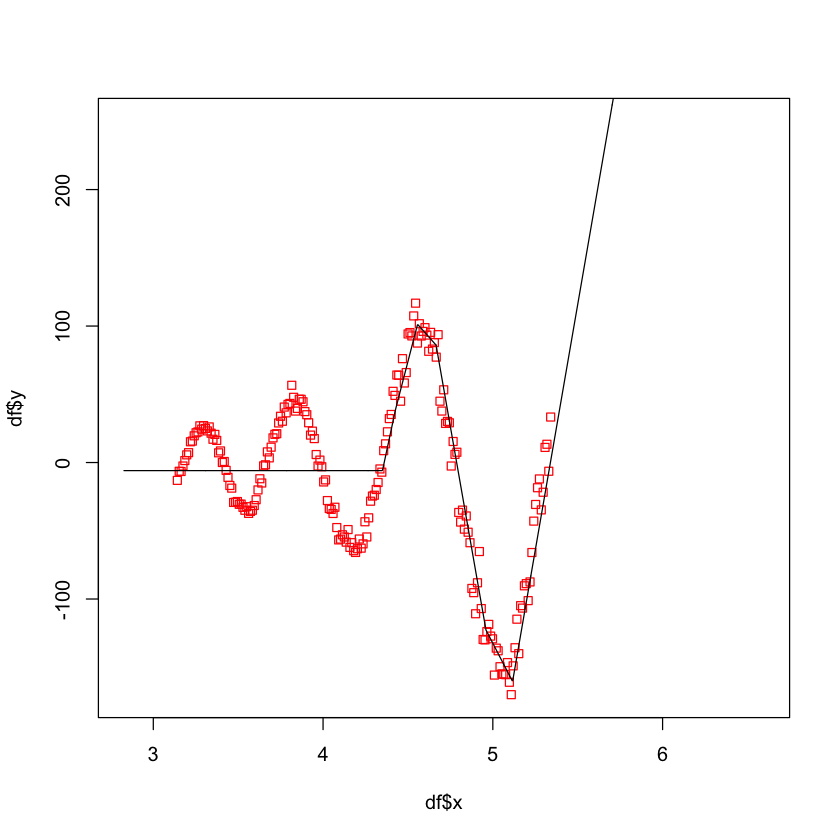

In [6]:
f <- regressor(df, "nn")
plt_reg(f, df_new)

------------------------------------------------------------------------

## Classification with Neural Networks

In [7]:
ex <- \(x) ifelse(
    ((abs(x[1]) + 0.05 * rnorm(1)  > 0.50 && abs(x[2]) + 0.05 * rnorm(1)  > 0.50)) || 
    ((abs(x[1]) + 0.05 * rnorm(1)  < 0.25 && abs(x[2]) + 0.05 * rnorm(1)  < 0.25)),
    1, 0
)

gen_classification_data <- function(n=500){
    X <- t(replicate(n, 2 * runif(2) - 1))
    y <- apply(X, 1, ex) %>% as.factor()
    col <- ifelse(y == 0, "blue", "red")
    df <- data.frame(y = y, x1 = X[, 1], x2 = X[, 2], col=col)
    return(df)
}

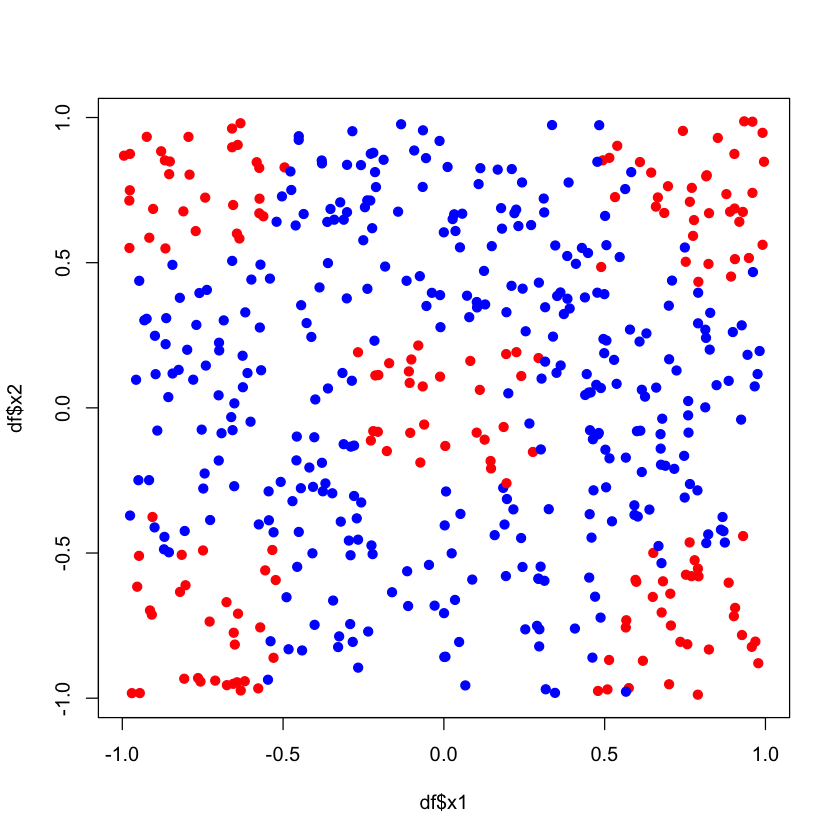

In [8]:
df <- gen_classification_data(500)
plot(df$x1, df$x2, col = df$col, pch = 19)

In [9]:
Xnew <- cbind(
    rep(seq(-1.1, 1.1, length.out=50), 50),
    rep(seq(-1.1, 1.1, length.out=50), each = 50)
)

df_new = data.frame(x1=Xnew[, 1], x2=Xnew[, 2])

plt <- function(f, x){
    plot(x[, 1], x[, 2], col=ifelse(f(x) < 0.5, "blue", "red"), pch=22)
    points(df$x1, df$x2, col= ifelse(y == "0", "blue", "red"), pch = 19)
}

overview <- function(f){
    predicted <- ifelse(f(df[, -1]) < 0.5, 0, 1)
    actual <- df[, 1]
    table(predicted, actual)
}

### Neural Network with 1 hidden layer

------------------------------------------------------------------------

In [12]:
p <- 2
q <- 20

hh1_module <- nn_module(
  initialize = function() {
      
    self$input_to_hidden <- nn_linear(p, q)
      
    self$hidden_to_output <- nn_linear(q, 1)
      
    self$activation <- nn_relu()
      
    self$sigmoid <- nn_sigmoid()
  },
  forward = function(x) {
    x %>% 
      self$input_to_hidden() %>% 
      self$activation() %>% 
      self$hidden_to_output() #%>% 
      self$sigmoid()
  }
)


q1 <- 100
q2 <- 20

hh2_module <- nn_module(
  initialize = function() {
    self$input_to_hidden1 <- nn_linear(p, q1)
    self$hidden1_to_hidden2 <- nn_linear(q1, q2)
    self$hidden2_to_output <- nn_linear(q2, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
  forward = function(x) {
    x %>% 
      self$input_to_hidden1() %>% 
      self$activation() %>% 
      self$hidden1_to_hidden2() %>% 
      self$activation() %>% 
      self$hidden2_to_output() %>% 
      self$sigmoid()
  }
)

------------------------------------------------------------------------

In [13]:
classifier <- 
function(train, type="nn", ...){
    
    if(type == "logistic"){
        f = \(x) glm(y ~ x1 + x2, train, family=binomial()) %>% 
                 predict(., x, type="response")
    }
    
    else if(type == "rpart"){
        f = \(x) 
            rpart(y ~ x1 + x2, df, method="class") %>% 
            predict(., x, type="class") %>% 
            as.numeric(.) - 1
    }
        
    else if(type == "svm"){
        f = \(x)
            svm(y ~ x1 + x2, df, kernel="radial") %>% 
            predict(., x) %>% 
            as.numeric(.) - 1
    } 
        
    else if(type == "nn"){
        X_tensor <- torch_tensor(train[, -1] %>% as.matrix(), dtype=torch_float())
        y_tensor <- torch_tensor(cbind(train$y %>% as.numeric() - 1), dtype=torch_float())
        F <- hh2_module()
        optimizer <- optim_adam(F$parameters, lr=0.05)
        epochs <- 1000

        for(i in 1:epochs){
            loss <- nn_bce_loss()(F(X_tensor), y_tensor)
            optimizer$zero_grad()
            loss$backward()
            optimizer$step()
        }
        f = \(x) as_array(F( torch_tensor(x %>% as.matrix(), dtype=torch_float()) ))
    }
    
    return(f)
}

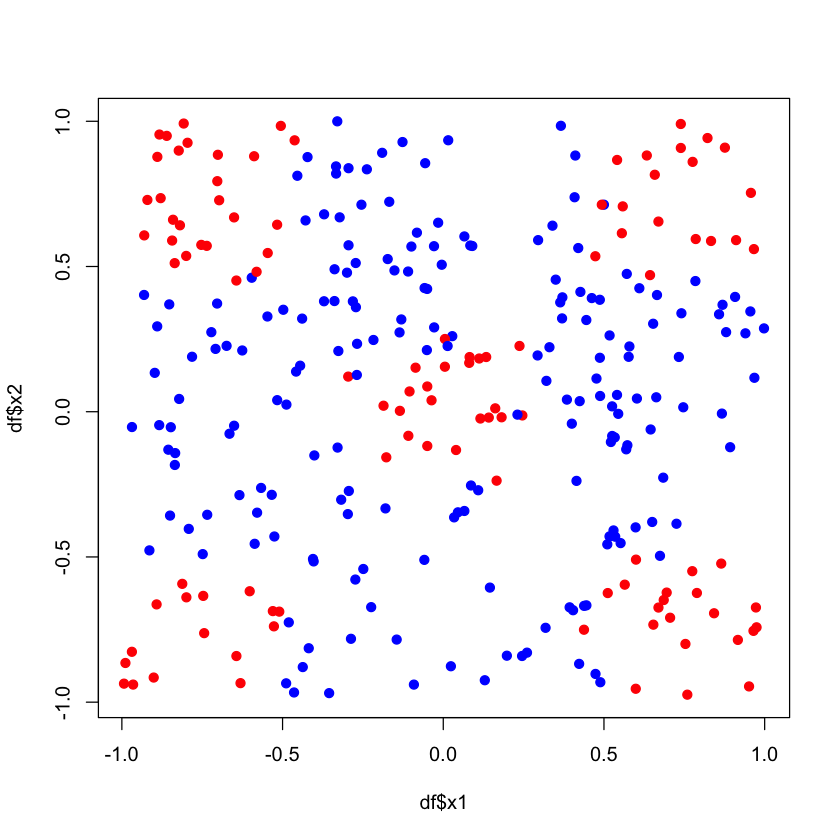

In [14]:
ex <- \(x) ifelse(
    ((abs(x[1]) + 0.05 * rnorm(1)  > 0.50 && abs(x[2]) + 0.05 * rnorm(1)  > 0.50)) || 
    ((abs(x[1]) + 0.05 * rnorm(1)  < 0.25 && abs(x[2]) + 0.05 * rnorm(1)  < 0.25)),
    1, 0
)


n <- 300
X <- t(replicate(n, 2 * runif(2) - 1))
y <- apply(X, 1, ex) %>% as.factor()
col <- ifelse(y == 0, "blue", "red")
df <- data.frame(y = y, x1 = X[, 1], x2 = X[, 2])
plot(df$x1, df$x2, col = col, pch = 19)

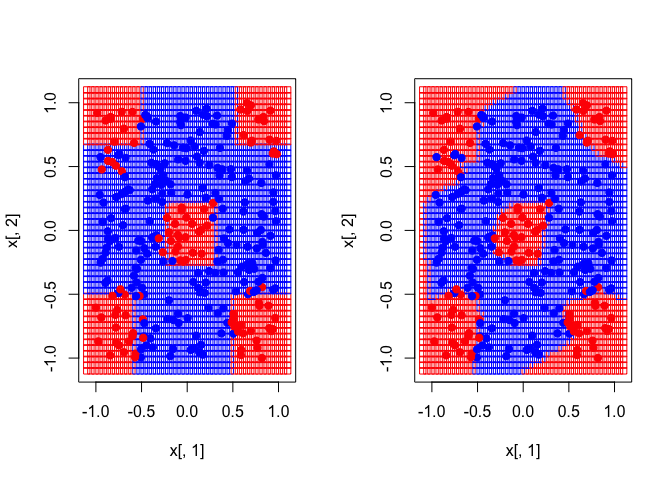

         actual
predicted   0   1
        0 190   5
        1   9  96

In [ ]:
options(repr.plot.width=15, repr.plot.height=7.5)
par(mfrow=c(1,2))

f <- classifier(df, "rpart")
plt(f, df_new)

f <- classifier(df, "nn")
plt(f, df_new)

------------------------------------------------------------------------

# Thu

### Agenda:

1.  Introduction to `Luz`
2.  Dataloaders
3.  Torch for image classification

### Luz

Luz is a higher level API for torch providing abstractions to allow for
much less verbose training loops. luz has three steps, the first one is setup.
The second step is to set the hyper-parameters.
The third and final step is to fit the model using the fit() function.

#### Allowing hyperparameters for NNs

In [17]:
nn_model <- nn_module(
    initialize = function(p, q1){
        self$hidden1 <- nn_linear(p, q1)
        self$output <- nn_linear(q1, 1)
        self$activation <- nn_relu()
        self$sigmoid <- nn_sigmoid()
    },
    forward = function(x){
        x %>% self$hidden1() %>%
        self$activation() %>%
        self$output() %>%
        self$sigmoid()
    }
)

In [15]:
x <- torch_randn(10, 10000)
x

torch_tensor
Columns 1 to 6 4.8408e-01 -4.3383e-01 -3.1046e-01  2.9263e-01 -1.6048e+00 -1.7660e-01
 1.2063e-01  8.2895e-02 -6.8149e-01 -3.5717e-01 -1.3977e+00 -4.0259e-02
-1.1856e+00  7.4791e-01  1.5157e+00  6.1007e-01 -1.0058e+00 -2.1493e-01
 1.3391e+00 -3.9100e-01 -1.1718e+00  2.8180e-01  1.9961e+00  2.8994e-01
-3.8398e-01  2.3236e-01 -3.3177e+00 -2.5924e+00 -5.8060e-01 -1.0219e+00
 2.9891e-01  7.9303e-02 -2.2916e+00 -5.2439e-01  1.2969e+00 -5.2561e-01
 4.5202e-01  1.7721e+00 -1.1834e+00 -2.0325e-01  2.6572e-01  9.4121e-01
-7.5633e-01 -2.2159e-01 -8.7445e-01 -1.2254e+00 -1.1167e-01  2.5021e-01
-2.9534e-01  1.9653e+00 -7.5687e-01  9.8308e-02 -3.3207e-01 -4.5753e-01
 1.2003e+00 -7.0100e-01 -1.8514e+00 -4.1888e-01 -2.5635e-01 -1.2318e+00

Columns 7 to 12 5.0581e-01  9.9627e-01 -5.5274e-01 -1.5074e-01 -6.0828e-01  1.6785e-01
-2.5705e-01 -1.6893e-01  1.9871e+00 -1.0818e-01  6.3640e-01  1.5137e-01
-1.9133e+00  1.9601e-01  3.1859e-01  1.0901e-01  7.3513e-01  2.0021e+00
 2.9336e-01  2.2163e-

In [18]:
nn_model(p=10000, q1 = 10)(x)

torch_tensor
 0.5363
 0.5301
 0.4710
 0.5435
 0.5311
 0.5191
 0.4871
 0.5298
 0.4856
 0.4977
[ CPUFloatType{10,1} ][ grad_fn = <SigmoidBackward0> ]

------------------------------------------------------------------------

#### Luz Setup

In [20]:
# renv::install("luz")
library(luz)

nn_model %>% 
    setup(loss = nn_bce_loss(), optimizer = optim_adam)

<luz_module_generator>

> This is equivalent to specifying:
>
>     F <- nn_model()
>     opt <- optim_adam(F$parameters)
>     ...
>     for(i in 1:...){
>         loss <- nn_bce_loss()(x, f(y))
>         ...
>     }

------------------------------------------------------------------------

#### Luz hyperparameters

In [21]:
nn_model <- nn_module(
    initialize = function(p, q1, q2, q3){
        self$hidden1 <- nn_linear(p, q1)
        self$hidden2 <- nn_linear(q1, q2)
        self$hidden3 <- nn_linear(q2, q3)
        self$output <- nn_linear(q3, 1)
        self$activation <- nn_relu()
        self$sigmoid <- nn_sigmoid()
    },
    forward = function(x){
        x %>% 
        self$hidden1() %>% self$activation() %>%
        self$hidden2() %>% self$activation() %>%
        self$hidden3() %>% self$activation() %>%
        self$output() %>% self$sigmoid()
    }
)

In [ ]:
nn_model %>% 
    setup(loss = nn_bce_loss(), optimizer = optim_adam) %>%
    set_hparams(p=2, q1 = 5, q2 = 7, q3 = 5) %>%
    set_opt_hparams(lr = 0.02)

> This is now equivalent to specifying:
>
>     F <- nn_model(p=2, q1=5, q2=7, q3=5)
>     opt <- optim_adam(lr=0.02)
>     ...
>     for(i in 1:...){
>         loss <- nn_bce_loss()(x, f(y))
>         ...
>     }

------------------------------------------------------------------------

#### Luz Fit

Epoch 1/10


Train metrics: Loss: 0.6682 - Acc: 20 - AUC: 0.4539
Valid metrics: Loss: 0.535 - Acc: 20 - AUC: 0.3
Epoch 2/10
Train metrics: Loss: 0.6382 - Acc: 21.5 - AUC: 0.4752
Valid metrics: Loss: 0.4565 - Acc: 20 - AUC: 0.4
Epoch 3/10
Train metrics: Loss: 0.6304 - Acc: 21.625 - AUC: 0.5016
Valid metrics: Loss: 0.4936 - Acc: 20 - AUC: 0.45
Epoch 4/10
Train metrics: Loss: 0.6213 - Acc: 21.75 - AUC: 0.5058
Valid metrics: Loss: 0.4795 - Acc: 20 - AUC: 0.4833
Epoch 5/10
Train metrics: Loss: 0.6222 - Acc: 21.5 - AUC: 0.5523
Valid metrics: Loss: 0.4776 - Acc: 20 - AUC: 0.5
Epoch 6/10
Train metrics: Loss: 0.6116 - Acc: 21.75 - AUC: 0.5337
Valid metrics: Loss: 0.4746 - Acc: 20 - AUC: 0.55
Epoch 7/10
Train metrics: Loss: 0.6145 - Acc: 21.625 - AUC: 0.5125
Valid metrics: Loss: 0.4696 - Acc: 20 - AUC: 0.5667
Epoch 8/10
Train metrics: Loss: 0.6061 - Acc: 21.75 - AUC: 0.5596
Valid metrics: Loss: 0.4429 - Acc: 20 - AUC: 0.6
Epoch 9/10
Train metrics: Loss: 0.6098 - Acc: 21.625 - AUC: 0.5365
Valid metrics: Loss:

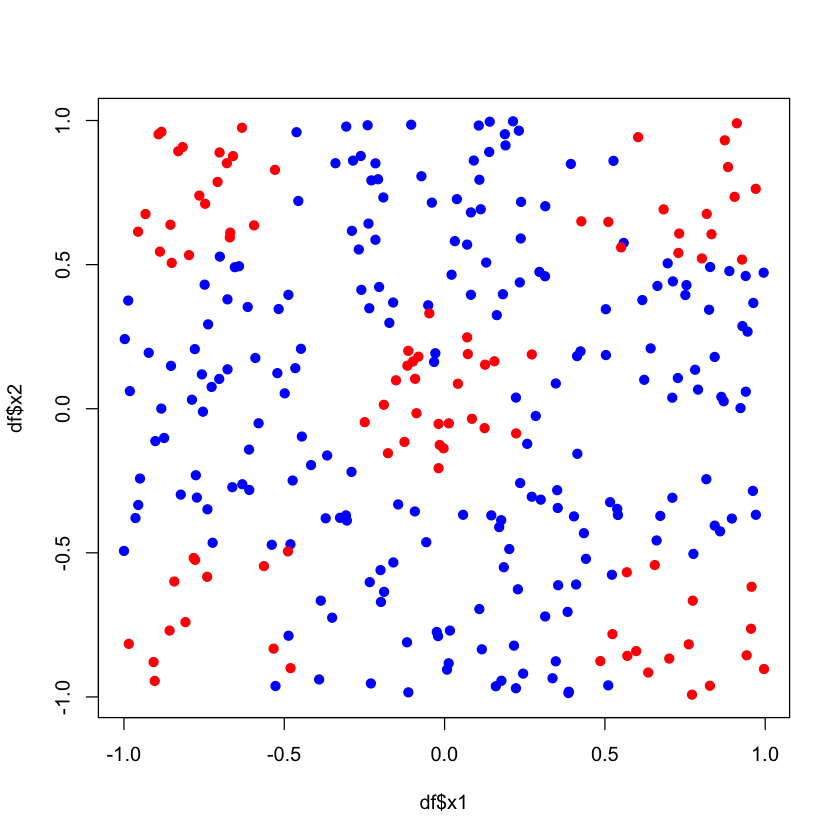

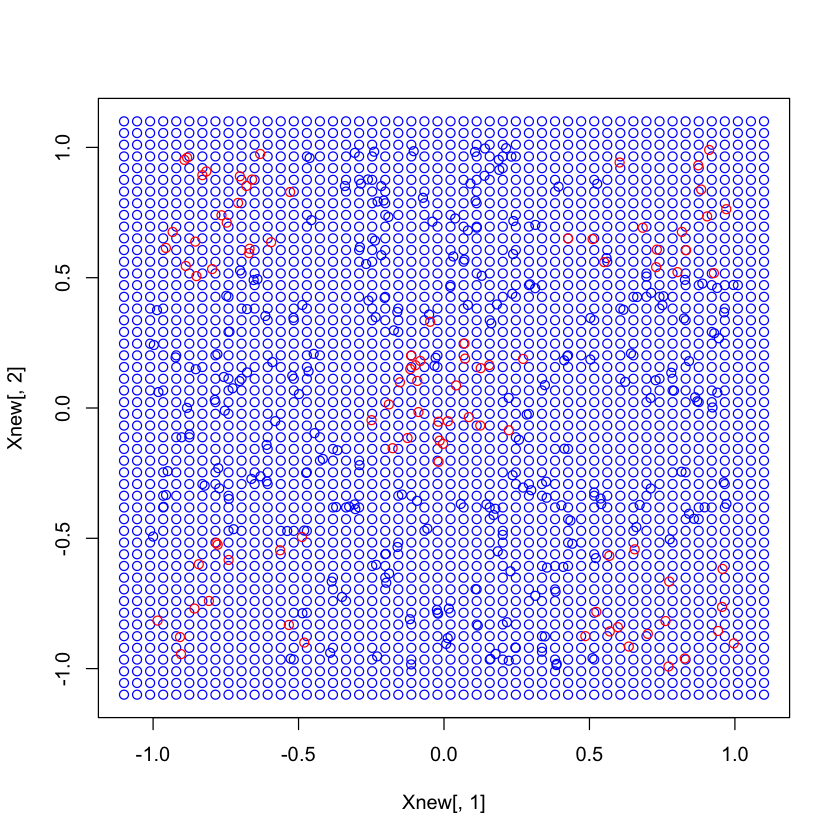

In [56]:
ex <- \(x) ifelse(
    ((abs(x[1]) + 0.05 * rnorm(1)  > 0.50 && abs(x[2]) + 0.05 * rnorm(1)  > 0.50)) || 
    ((abs(x[1]) + 0.05 * rnorm(1)  < 0.25 && abs(x[2]) + 0.05 * rnorm(1)  < 0.25)),
    1, 0
)


n <- 300
X <- t(replicate(n, 2 * runif(2) - 1))
y <- apply(X, 1, ex) %>% as.factor()
col <- ifelse(y == 0, "blue", "red")
df <- data.frame(y = y, x1 = X[, 1], x2 = X[, 2])
plot(df$x1, df$x2, col = col, pch = 19)

Xnew <- cbind(
    rep(seq(-1.1, 1.1, length.out=50), 50),
    rep(seq(-1.1, 1.1, length.out=50), each = 50)
)

df_new = data.frame(x1=Xnew[, 1], x2=Xnew[, 2])

fit_nn <- nn_model %>% 
    setup(loss = nn_bce_loss(), 
        optimizer = optim_adam,
        metrics = list(
            luz_metric_binary_accuracy(), 
            luz_metric_binary_auroc())) %>%
    set_hparams(p=2, q1 = 5, q2 = 7, q3 = 5) %>%
    set_opt_hparams(lr = 0.02) %>%
    fit(data = list(as.matrix(df[-test_ind,-1]), 
                    as.numeric(df[-test_ind,1]) - 1),
        valid_data = list(as.matrix(df[+test_ind,-1]),
                    as.numeric(df[+test_ind,1]) - 1),
        epochs = 10, verbose = TRUE)

cols <- ifelse(as_array(predict(fit_nn, Xnew)) > 0.5, "red", "blue")
plot(Xnew[, 1], Xnew[, 2], col=cols)
points(df$x1, df$x2, col=col)

In [53]:
plt_reg <- function(f, x,...){
    ynew <- f(x)
    ylim <- range(c(ynew, df$y))
    ylim[1] <- max(c(-800, ylim[1]))
    ylim[2] <- min(c(250, ylim[2]))
    xlim <- range(x)
    
    plot(df$x, df$y, pch = 22, col="red", xlim=xlim, ylim=ylim,...)
    points(x[, 1], ynew, pch=22, type="l")
}


ERROR: Error in (function (input, weight, bias) : mat1 and mat2 shapes cannot be multiplied (2500x2 and 1x20)
Exception raised from meta at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/LinearAlgebra.cpp:170 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >) + 81 (0x10a3ccca1 in libc10.dylib)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 98 (0x10a3cb342 in libc10.dylib)
frame #2: at::meta::structured_addmm::meta(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&) + 1173 (0x12eb496b5 in libtorch_cpu.dylib)
frame #3: c10::impl::wrap_kernel_functor_unboxed_<c10::impl::detail::WrapFunctionIntoFunctor_<c10::CompileTimeFunctionPointer<at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&), &(at::(anonymous namespace)::wrapper_CPU_addmm(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&))>, at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&> >, at::Tensor (at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&)>::call(c10::OperatorKernel*, c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&) + 80 (0x12fb7a1e0 in libtorch_cpu.dylib)
frame #4: at::_ops::addmm::redispatch(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&) + 126 (0x12f3a317e in libtorch_cpu.dylib)
frame #5: torch::autograd::VariableType::(anonymous namespace)::addmm(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&) + 3528 (0x1311eae68 in libtorch_cpu.dylib)
frame #6: c10::impl::wrap_kernel_functor_unboxed_<c10::impl::detail::WrapFunctionIntoFunctor_<c10::CompileTimeFunctionPointer<at::Tensor (c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&), &(torch::autograd::VariableType::(anonymous namespace)::addmm(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&))>, at::Tensor, c10::guts::typelist::typelist<c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&> >, at::Tensor (c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&)>::call(c10::OperatorKernel*, c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&) + 41 (0x1311e9db9 in libtorch_cpu.dylib)
frame #7: at::_ops::addmm::call(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&) + 373 (0x12f3a2e75 in libtorch_cpu.dylib)
frame #8: at::native::linear(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&) + 222 (0x12eb360ce in libtorch_cpu.dylib)
frame #9: c10::impl::wrap_kernel_functor_unboxed_<c10::impl::detail::WrapFunctionIntoFunctor_<c10::CompileTimeFunctionPointer<at::Tensor (at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&), &(at::(anonymous namespace)::(anonymous namespace)::wrapper_CompositeImplicitAutograd__linear(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&))>, at::Tensor, c10::guts::typelist::typelist<at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&> >, at::Tensor (at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&)>::call(c10::OperatorKernel*, c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&) + 23 (0x12feeecb7 in libtorch_cpu.dylib)
frame #10: at::_ops::linear::call(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&) + 333 (0x12f373a3d in libtorch_cpu.dylib)
frame #11: at::linear(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&) + 51 (0x114408683 in liblantern.dylib)
frame #12: _lantern_linear_tensor_tensor_tensor + 323 (0x114407fa3 in liblantern.dylib)
frame #13: cpp_torch_namespace_linear_input_Tensor_weight_Tensor(XPtrTorchTensor, XPtrTorchTensor, XPtrTorchOptionalTensor) + 64 (0x1107c5b30 in torchpkg.so)
frame #14: _torch_cpp_torch_namespace_linear_input_Tensor_weight_Tensor + 492 (0x110287c5c in torchpkg.so)
frame #15: R_doDotCall + 1458 (0x108ce7a62 in libR.dylib)
frame #16: bcEval + 104269 (0x108d3396d in libR.dylib)
frame #17: Rf_eval + 385 (0x108d19b81 in libR.dylib)
frame #18: R_execClosure + 2169 (0x108d399b9 in libR.dylib)
frame #19: Rf_applyClosure + 471 (0x108d387a7 in libR.dylib)
frame #20: Rf_eval + 1595 (0x108d1a03b in libR.dylib)
frame #21: do_docall + 641 (0x108cb5871 in libR.dylib)
frame #22: bcEval + 28565 (0x108d211b5 in libR.dylib)
frame #23: Rf_eval + 385 (0x108d19b81 in libR.dylib)
frame #24: R_execClosure + 2169 (0x108d399b9 in libR.dylib)
frame #25: Rf_applyClosure + 471 (0x108d387a7 in libR.dylib)
frame #26: bcEval + 26766 (0x108d20aae in libR.dylib)
frame #27: Rf_eval + 385 (0x108d19b81 in libR.dylib)
frame #28: R_execClosure + 2169 (0x108d399b9 in libR.dylib)
frame #29: Rf_applyClosure + 471 (0x108d387a7 in libR.dylib)
frame #30: bcEval + 26766 (0x108d20aae in libR.dylib)
frame #31: Rf_eval + 385 (0x108d19b81 in libR.dylib)
frame #32: R_execClosure + 2169 (0x108d399b9 in libR.dylib)
frame #33: Rf_applyClosure + 471 (0x108d387a7 in libR.dylib)
frame #34: bcEval + 26766 (0x108d20aae in libR.dylib)
frame #35: Rf_eval + 385 (0x108d19b81 in libR.dylib)
frame #36: R_execClosure + 2169 (0x108d399b9 in libR.dylib)
frame #37: Rf_applyClosure + 471 (0x108d387a7 in libR.dylib)
frame #38: bcEval + 26766 (0x108d20aae in libR.dylib)
frame #39: Rf_eval + 385 (0x108d19b81 in libR.dylib)
frame #40: R_execClosure + 2169 (0x108d399b9 in libR.dylib)
frame #41: Rf_applyClosure + 471 (0x108d387a7 in libR.dylib)
frame #42: Rf_eval + 1595 (0x108d1a03b in libR.dylib)
frame #43: do_begin + 462 (0x108d3c30e in libR.dylib)
frame #44: Rf_eval + 887 (0x108d19d77 in libR.dylib)
frame #45: R_execClosure + 2169 (0x108d399b9 in libR.dylib)
frame #46: Rf_applyClosure + 471 (0x108d387a7 in libR.dylib)
frame #47: Rf_eval + 1595 (0x108d1a03b in libR.dylib)
frame #48: forcePromise + 172 (0x108d37ebc in libR.dylib)
frame #49: Rf_eval + 1124 (0x108d19e64 in libR.dylib)
frame #50: forcePromise + 172 (0x108d37ebc in libR.dylib)
frame #51: Rf_eval + 1124 (0x108d19e64 in libR.dylib)
frame #52: forcePromise + 172 (0x108d37ebc in libR.dylib)
frame #53: getvar + 778 (0x108d434ba in libR.dylib)
frame #54: bcEval + 15047 (0x108d1dce7 in libR.dylib)
frame #55: Rf_eval + 385 (0x108d19b81 in libR.dylib)
frame #56: forcePromise + 172 (0x108d37ebc in libR.dylib)
frame #57: Rf_eval + 522 (0x108d19c0a in libR.dylib)
frame #58: do_mget + 1431 (0x108d085c7 in libR.dylib)
frame #59: bcEval + 28565 (0x108d211b5 in libR.dylib)
frame #60: Rf_eval + 385 (0x108d19b81 in libR.dylib)
frame #61: R_execClosure + 2169 (0x108d399b9 in libR.dylib)
frame #62: Rf_applyClosure + 471 (0x108d387a7 in libR.dylib)
frame #63: bcEval + 26766 (0x108d20aae in libR.dylib)



In [30]:
fit_nn <- nn_model %>% 
    setup(loss = nn_bce_loss(), optimizer = optim_adam) %>%
    set_hparams(p=2, q1 = 5, q2 = 7, q3 = 5) %>%
    set_opt_hparams(lr = 0.02) %>%
    fit(data = list(as.matrix(df[,-1]), 
                    as.numeric(df[,1]) - 1), 
                    epochs = 10, verbose = TRUE)


Epoch 1/10


Train metrics: Loss: 0.6303
Epoch 2/10
Train metrics: Loss: 0.6168
Epoch 3/10
Train metrics: Loss: 0.6088
Epoch 4/10
Train metrics: Loss: 0.6074
Epoch 5/10
Train metrics: Loss: 0.5935
Epoch 6/10
Train metrics: Loss: 0.5926
Epoch 7/10
Train metrics: Loss: 0.5659
Epoch 8/10
Train metrics: Loss: 0.5314
Epoch 9/10
Train metrics: Loss: 0.5181
Epoch 10/10
Train metrics: Loss: 0.4941


> This now becomes equivalent to:
>
>     F <- nn_model(p=2, q1=5, q2=7, q3=5)
>     opt <- optim_adam(lr=0.02)
>
>     x <- torch_tensor(as.matrix(df[, -1]),     dtype=torch_float())
>     y <- torch_tensor(as.numeric(df[, 1]) - 1, dtype=torch_float())
>
>     for(i in 1:epochs){
>         loss <- nn_bce_loss()(x, f(y))
>         optimizer\$zero_grad()
>         loss\$backward()
>         optimizer\$step()
>         print(paste0("Train metrics: Loss: ", loss))
>     }

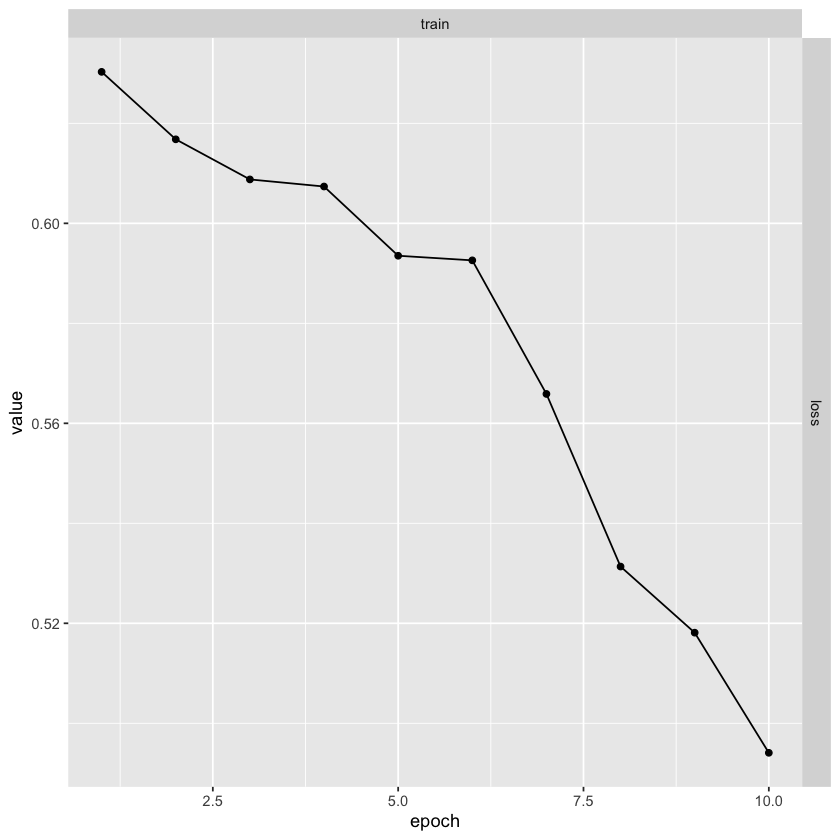

In [31]:
plot(fit_nn)

The output of Luz allows you to use the familiar predict function

In [32]:
predict(fit_nn, cbind(rnorm(10), rnorm(10))) %>% as_array

0.4383176
0.2368205
0.9861798
0.1664341
0.2320869
0.2366236
0.2245821
0.9518067
0.1189724
0.4689022


------------------------------------------------------------------------

#### Luz validation Data

In [35]:
test_ind <- sample(1:nrow(df), 23, replace = FALSE)
test_ind

[1] 247 198 234 201 154 109 218  52 107 159  54 176  84  37 167  75 106 121  29
[20] 148 162 188  83

In [36]:
fit_nn <- nn_model %>% 
    setup(loss = nn_bce_loss(), optimizer = optim_adam) %>%
    set_hparams(p=2, q1 = 5, q2 = 7, q3 = 5) %>%
    set_opt_hparams(lr = 0.02) %>%
    fit(data = list(as.matrix(df[-test_ind,-1]), 
                    as.numeric(df[-test_ind,1]) - 1),
        valid_data = list(as.matrix(df[+test_ind,-1]),
                    as.numeric(df[+test_ind,1]) - 1),
        epochs = 10, verbose = TRUE)

Epoch 1/10
Train metrics: Loss: 0.655
Valid metrics: Loss: 0.6146
Epoch 2/10
Train metrics: Loss: 0.6447
Valid metrics: Loss: 0.5919
Epoch 3/10
Train metrics: Loss: 0.6239
Valid metrics: Loss: 0.5757
Epoch 4/10
Train metrics: Loss: 0.6277
Valid metrics: Loss: 0.5646
Epoch 5/10
Train metrics: Loss: 0.6151
Valid metrics: Loss: 0.5564
Epoch 6/10
Train metrics: Loss: 0.608
Valid metrics: Loss: 0.5491
Epoch 7/10
Train metrics: Loss: 0.6124
Valid metrics: Loss: 0.5445
Epoch 8/10
Train metrics: Loss: 0.6022
Valid metrics: Loss: 0.5419
Epoch 9/10
Train metrics: Loss: 0.6017
Valid metrics: Loss: 0.54
Epoch 10/10
Train metrics: Loss: 0.6152
Valid metrics: Loss: 0.5388


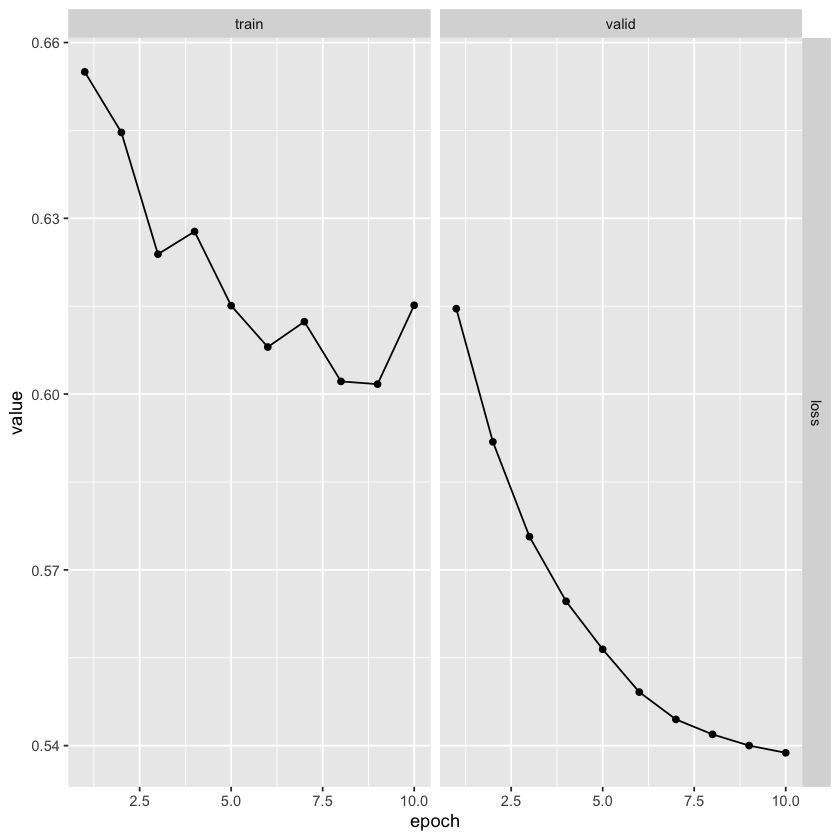

In [37]:
plot(fit_nn)

------------------------------------------------------------------------

#### Luz metrics

Luz metrics allow you to examine metrics other than the loss function
during the NNet training procedure

In [44]:
predicted <- torch_tensor(sample(0:1, 100, replace = TRUE))
expected <- torch_tensor(sample(0:1, 100, replace = TRUE))
metric <- luz_metric_binary_accuracy()

metric <- metric$new()
metric$update(predicted, expected)
metric$compute()

[1] 0.5

> predicted \<- torch_cat(list(torch_zeros(50), torch_ones(50)))
>
> expected \<- torch_cat(list(torch_ones(50), torch_zeros(50)))
>
> metric \<- luz_metric_binary_accuracy()

In [ ]:
fit_nn <- nn_model %>% 
    setup(loss = nn_bce_loss(), 
            optimizer = optim_adam, 
            metrics = list(luz_metric_binary_accuracy(), luz_metric_binary_auroc())) %>%
    set_hparams(p=2, q1 = 5, q2 = 7, q3 = 5) %>%
    set_opt_hparams(lr = 0.02) %>%
    fit(data = list(as.matrix(df[,-1]), 
                    as.numeric(df[,1]) - 1), 
        epochs = 10, verbose = TRUE)

------------------------------------------------------------------------

#### Putting it all together

In [47]:
fit_nn <- nn_model %>% 
    setup(loss = nn_bce_loss(), 
        optimizer = optim_adam,
        metrics = list(
            luz_metric_binary_accuracy(), 
            luz_metric_binary_auroc())) %>%
    set_hparams(p=2, q1 = 5, q2 = 7, q3 = 5) %>%
    set_opt_hparams(lr = 0.02) %>%
    fit(data = list(as.matrix(df[-test_ind,-1]), 
                    as.numeric(df[-test_ind,1]) - 1),
        valid_data = list(as.matrix(df[+test_ind,-1]),
                    as.numeric(df[+test_ind,1]) - 1),
        epochs = 10, verbose = TRUE)

Epoch 1/10


Train metrics: Loss: 0.6555 - Acc: 20.3125 - AUC: 0.4749
Valid metrics: Loss: 0.5448 - Acc: 18 - AUC: 0.2556
Epoch 2/10
Train metrics: Loss: 0.623 - Acc: 22.25 - AUC: 0.4456
Valid metrics: Loss: 0.5373 - Acc: 18 - AUC: 0.2667
Epoch 3/10
Train metrics: Loss: 0.6101 - Acc: 22.25 - AUC: 0.5213
Valid metrics: Loss: 0.5545 - Acc: 18 - AUC: 0.4111
Epoch 4/10
Train metrics: Loss: 0.6064 - Acc: 22.25 - AUC: 0.5813
Valid metrics: Loss: 0.5469 - Acc: 18 - AUC: 0.4333
Epoch 5/10
Train metrics: Loss: 0.5946 - Acc: 22.5 - AUC: 0.5689
Valid metrics: Loss: 0.5295 - Acc: 18 - AUC: 0.4111
Epoch 6/10
Train metrics: Loss: 0.5947 - Acc: 22.375 - AUC: 0.5847
Valid metrics: Loss: 0.5307 - Acc: 18 - AUC: 0.4889
Epoch 7/10
Train metrics: Loss: 0.5813 - Acc: 22.875 - AUC: 0.5814
Valid metrics: Loss: 0.5307 - Acc: 18 - AUC: 0.4778
Epoch 8/10
Train metrics: Loss: 0.605 - Acc: 21.875 - AUC: 0.5758
Valid metrics: Loss: 0.5274 - Acc: 18 - AUC: 0.5
Epoch 9/10
Train metrics: Loss: 0.5963 - Acc: 21.875 - AUC: 0.6076
V

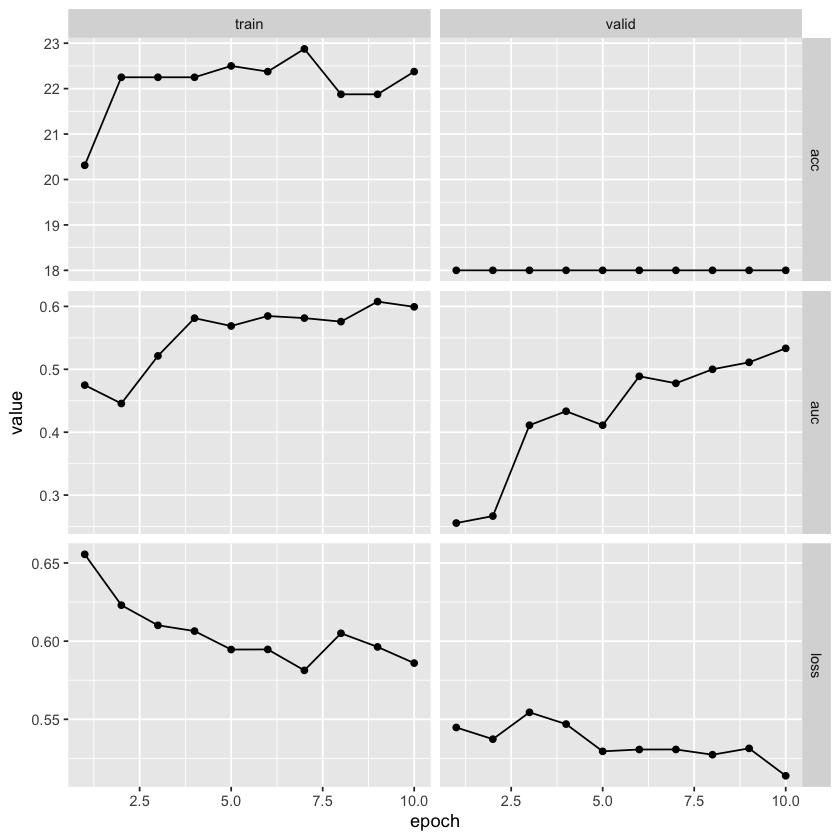

In [48]:
plot(fit_nn)

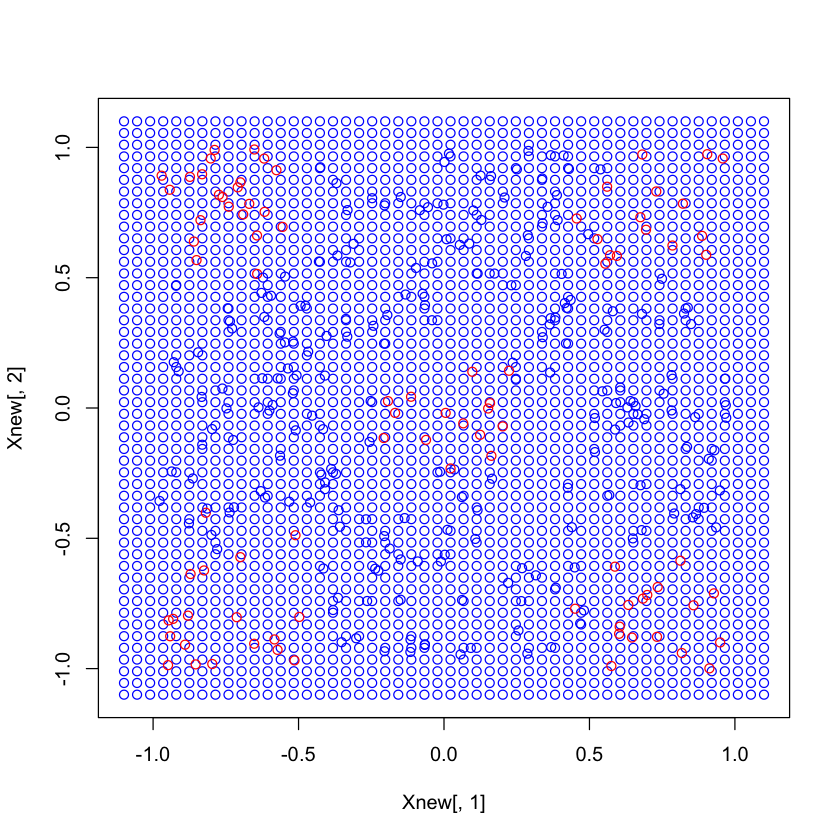

In [54]:


cols <- ifelse(as_array(predict(fit_nn, Xnew)) > 0.5, "red", "blue")
plot(Xnew[, 1], Xnew[, 2], col=cols)
points(df$x1, df$x2, col=col)

ROC stands for "Receiver Operating Characteristic," and it is a graphical plot that illustrates the performance of a binary classification model across different thresholds. The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1 - specificity) for various threshold values.

The AUC is a scalar value representing the area under the ROC curve. It quantifies the overall performance of the classification model across all possible threshold values. A higher AUC value indicates better discriminative ability of the model - in other words, it suggests that the model has better ability to distinguish between the two classes.

An AUC of 1 represents a perfect classifier, while an AUC of 0.5 represents a classifier that performs no better than random guessing. Typically, an AUC value between 0.5 and 1 indicates that the model has some level of discriminative ability, with higher values being desirable.





------------------------------------------------------------------------

#### Final result